# Final Project: MovieLens Recommender System
Amanda Steigman (as5937), Suman Tripathy (st3275), Romane Goldmuntz (rsg2163)

## 1. Business Objectives

Using the MovieLens dataset, our goal is to build a hybrid recommender system that can recommend a "Top 10" movie list for each user. We choose to give the user a larger selection of potential movies to choose from, rather than, for example, showing a "Top 5," in order to improve the chances that at least one of the movies we show will be relevant to the user. It is also common for people to scroll through many movie and show suggestions on platforms like Netflix and Amazon Prime before choosing a certain one.


We compare our hybrid approach to two baselines - one in which we simply predict that a user will rate a movie as the average rating the movie has received across all users, and one item-based collaborative filtering recommender. We explore using this item-based recommender in our hybrid system as well.

With the user in mind, as mentioned above, for our baseline collaborative filtering algorithm and our first attempt at fitting a hybrid system, we use item-based filtering. The reasons behind that choice are three-fold. First, the number of items is usually much lower than the number of users and new items are added less frequently than new users, which makes the computation time for item-based collaborative filtering much faster than user-based collaborative filtering. The stability of item-based models is also higher than user-based filtering because items will likely overlap more often than users. Finally, we considered interpretability: item-based collaborative filtering enables us to provide the user with an intuitive explanation, such as "Because you liked movie X, you may enjoy movie Y as well."

For our hybrid recommender system, we try three different approaches, with all three including the item-based collaborative filtering because of its strong performance. In our model, different types of users are routed through different recommendation algorithms. We define three broad types of users: (1) those who rarely watch movies (i.e. those at or below the 25th percentile for number of movies watched), (2) the typical user who has watched a moderate number of movies (i.e. those between the 25th and 75th percentile), and (3) the frequent movie watcher (i.e. users who have watched at or above the 75th percentile of movies). Our cutoff to be included in the infrequent movie watcher bin is 16, and our threshold to be included in the frequent movie watcher bin is 41.

The switching system is a type of parallel ensemble model which allows us to change the algorithm we use based on individuals. In this way, we can also change the way we are recommending movies for a particular user if his "type" changes as he watches more movies. 

In the three hybrid systems we build, we integrate various combinations of Item-Based Collaborative Filtering, Content-Based Recommendation, and Autoencoders. We only use autoencoders to recommend movies to the frequent (type 3) users. Autoencoders, which create latent representations using an encoder-decoder framework, allow us to obtain dense embeddings and are thus useful for making predictions in high-dimensional spaces (i.e. ones where users have watched a large number of movies). In our first and third hybrid system, we use a content-based algorithm to recommend movies to our infrequent users and item-based collaborative filter to recommend movies to our typical users respectively. We are curious to see if this helps relieve the cold start problem for Item-Based Collaborative Filtering, which typically does not perform well on users with few ratings. However, in our second hybrid system, we once again use Collaborative Filtering to recommend movies to both our infrequent and typical users.

In the content-based recommender, we include additional information about each movie (explored below) to represent them as high-dimensional vectors. We thought this may be useful if a user has only watched a small number of movies since it doesn't depend on other movies watched and rated, and instead allows us to learn more about the users' preferences in terms of genre, actors, directors, etc. These movie vectors are used to create personalized user profiles for the purpose of making recommendations, which we will leverage Approximate Nearest Neighbors (ANN) to do. Since searching for all of the closest movies in a high-dimensional space is computationally expensive, ANN will help with scaling our recommender system. With ANN, we take a tree-based approach that builds randomized trees partitioned along random dimensions from our data and searches them in parallel to save time. Content-based recommenders are also a good choice of algorithm with the user in mind, since they are easily explainable. For example, additional information about a movie can allow us to tell a user, "You like comedies with female leads, so we recommend you watch Movie Z."

We believe the content-based algorithm may also be useful for our typical users since we still have less information available to make recommendations to them than we do for the frequent users, which is why we test it for User Types 1 and 2. Additionally, it is possible that infrequent and typical users are actually quite similar and many of the infrequent users may become typical users over time, so the same approach for recommendations may be useful for both group. However, we also try using the item-based CF for these user groups to account for the possibility that including too much information about too many movies may lead to recommendations that are not generalizable.

Since we are working with a huge dataset - around 27 million movie ratings - and because of the inherent sparsity of user-items matrices (i.e. most users do not rate most items) that make recommendations more difficult, we decide to work with a sample of the movie ratings. Because of the dependency between users and items, we cannot randomly sample the dataset. Therefore, we want to include only users who have rated at least a certain number of movies as well as only include movies that have received ratings from at least a certain number of users. We will explore this further in the Sampling section of our report. This will help improve the density of our user-item matrix and make it easier for our recommenders to learn relationships between users and items.

As we sample, we choose strategies that follow certain business logic. As mentioned above, we want to ensure as dense a user-item matrix as possible. So, we look at the mean user ratings per movie and the mean number of ratings per user. We sample from the subsets of movies and users, each with above average numbers of ratings respectively. By doing so, we do not only focus on the most popular movies and thus avoid adding bias into our model.

We also considered what performance requirements our recommendation system needed to fulfill. We generally assume that users may watch TV / movies after work daily, so we want to pre-compute recommendations offline but we also assume there is no major time crunch. Therefore, we don't worry greatly about space or time constraints, and we simply build these models as offline computations that should simply appear when a user is searching for a movie.

Before we begin, we import all necessary packages and start a Spark session.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.sql import Row
from sklearn.metrics import mean_squared_error
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit, CrossValidatorModel
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.types import StringType,IntegerType,DoubleType
from pyspark.sql.functions import col, countDistinct
from pyspark.sql import functions
from collections import defaultdict
from surprise.prediction_algorithms import KNNWithMeans
from surprise.model_selection import cross_validate
from surprise import accuracy
import pickle
import random
import time
import seaborn
from surprise import Reader, Dataset
from IPython.display import HTML, display
import tabulate
import random

In [2]:
spark = SparkSession.builder.appName("PersProj").getOrCreate()

## 2. Sampling

### 2.1 Explore the Data

First, we look at the total number of users and movies included in the ratings dataset by MovieLens. Since each row is a user-movie rating pair, every user included must have rated at least one movie and every movie included must have been rated by at least one user. We see below that there are 283,228 unique users who have rated at least one movie and 53,889 movies that have at least one rating. For our purposes, we only need to include at least 20,000 users and 1,000 movies. Therefore we sample the data based on our business rules as stated above. 

In [3]:
# Contains users and their respective movie ratings (float, out of 5.0) and timestamp of the rating
ratings = pd.read_csv("inputs/ratings.csv")
print(ratings.shape)
print(ratings.columns)
print(len(ratings['userId'].unique()), "unique users")
print(len(ratings['movieId'].unique()), "unique movies")

(27753444, 4)
Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
283228 unique users
53889 unique movies


Next, we look at the distribution of ratings by users. Some users really did only rate one movie, and, on the other extreme, the maximum number of movies rated by a user was close to 24,000 (almost half of the movies in our dataset!). The mean number of movies rated was around 100. When we subset our data before sampling, we will use the mean number of movies rated as our minimum threshold for inclusion.

In [4]:
# group by users & count their number of ratings
ratings_users = ratings.groupby('userId').size()
print('Min # of ratings:', min(ratings_users))
print('Max # of ratings:', max(ratings_users))
print('Avg # of ratings:', float(sum(ratings_users))/len(ratings_users))

Min # of ratings: 1
Max # of ratings: 23715
Avg # of ratings: 97.98976089934611


Moving forward, for movies, we can see that 1 was the minimum number of ratings received. The maximum number of ratings a movie received was around 98,000, meaning nearly 35% of users rated that movie. On average, a movie received 515 ratings (meaning it was rated by around 0.2% of users). Any movie that received at least this number of ratings (515) can be included in our sample.

In [5]:
# group by movies & count their number of ratings
ratings_movies = ratings.groupby('movieId').size()
print('Min # of ratings:', min(ratings_movies))
print('Max # of ratings:', max(ratings_movies))
print('Avg # of ratings:', float(sum(ratings_movies))/len(ratings_movies))

Min # of ratings: 1
Max # of ratings: 97999
Avg # of ratings: 515.0113010076268


### 2.2 Obtain sample and get user-items matrix

We first subset the ratings dataset by filtering based on the mean number of movie ratings and then based on the mean number of user ratings. The data is very skewed because there are many movies with very few reviews. Therefore, by subsetting based on the mean, we are picking a less sparse dataset that is also not just the most popular movies. 

In [6]:
m = ratings.groupby('movieId').size()
movies_with_many_ratings = list(m[m > m.mean()].index)
movies_with_many_ratings = ratings.loc[ratings['movieId'].isin(movies_with_many_ratings)]

u = ratings.groupby('userId').size()
user_subset = list(u[u > u.mean()].index)
user_ratings = movies_with_many_ratings.loc[movies_with_many_ratings['userId'].isin(user_subset)]
user_ratings.head()

,userId,movieId,rating,timestamp
42,4,1,4.0,1113765937
43,4,2,4.0,1113767306
44,4,5,2.0,1123990453
45,4,6,4.5,1113767242
46,4,10,4.0,1113765995


From these movies, we then randomly sample lists of 1000 movie IDs and 20000 user IDs from the filtered dataset and use those IDs to get our sample.

In [7]:
sample_movieIds = random.sample(list(user_ratings['movieId'].unique()), 1000)
sample_ratings = user_ratings.loc[user_ratings['movieId'].isin(sample_movieIds)]
sample_userIds = random.sample(list(sample_ratings['userId'].unique()), 20000)
sample_ratings = sample_ratings.loc[sample_ratings['userId'].isin(sample_userIds)]
sample_ratings.to_csv("sample_ratings.csv")
sample_ratings.shape

(1053727, 4)

In [8]:
print("Unique movies", len(sample_ratings['movieId'].unique()))
print("Unique users", len(sample_ratings['userId'].unique()))

Unique movies 1000
Unique users 20000


Finally, we want to see how our sample's density compares to our original sparse data's density. To do this, we must convert the sampled ratings dataset into a user-item matrix. We see that the new density of our user-items matrix is about 5% as compared to our previous density of about 0.2%. This is clearly a significant improvement.

In [9]:
user_movies = sample_ratings.pivot_table(index = 'userId', columns = 'movieId', values = 'rating')

# calculate density
nulls = user_movies.isnull().sum().sum()
density = (user_movies.shape[0]*user_movies.shape[1]-nulls)/(user_movies.shape[0]*user_movies.shape[1])*100
print(str(density)+'%')

5.268635%


### 2.3 Webscraping additional data

Since we are building a content-based recommender system, we needed to get additional data on the movies included in our sample. The MovieLens dataset comes with tags for each movie, and we combined this with named links and category metadata about the movies that we scraped from Wikipedia pages about each movie. The Wikipedia notebook contains the work done to scrape Wikipedia and clean its output, so this step will be skipped here and we simply read in the data table we generated from that Wikipedia notebook. After removing extremely rare and extremely common tags, as neither would be useful for prediction, we had around 2500 content-based tags describing the movies in our sample. These tags include information about genre, themes, release year, awards nominated for, location, etc.

In [3]:
#get top tags
movie_vecs = pd.read_csv('inputs/movie_tag_wiki_vecs.csv', index_col=0)

In [4]:
movie_tags = movie_vecs.sum(axis=0).to_frame()
movie_tags.columns = ['Frequency']

We can see below that the tags have a long right tail - there are a small number of tags that appear more than 200 times, but the majority of tags appear between 20 and 60 times.

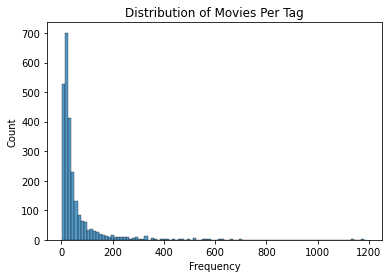

In [5]:
#distribution of tag freqs
seaborn.histplot(movie_tags[movie_tags['Frequency']<1500]['Frequency'],bins=100)
plt.title('Distribution of Movies Per Tag')
plt.show()

We next look at the number of tags per movie, which also has a right tail, albeit a smaller one. The majority of movies, though, have between 45 and 200 tags associated with them.

In [6]:
#count of tags per movie
tags_per_movie = movie_vecs.sum(axis=1).to_frame()
tags_per_movie.columns = ['Frequency']

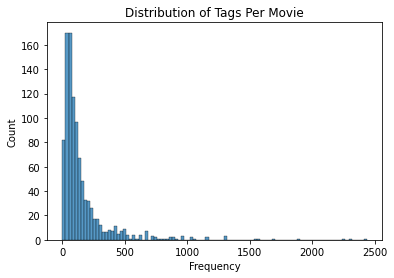

In [7]:
seaborn.histplot(tags_per_movie['Frequency'],bins=100)
plt.title('Distribution of Tags Per Movie')
plt.show()

### 2.4 Define metrics
Here, we define the three important metrics that we will use to evaluate and improve our models: precision, recall, and novelty.

Since we are interested in measuring our success in movie recommendation, we include precision as a metric for evaluating our recommender systems. In other words, we care more about ensuring that we are showing the users a high ratio of movies that they will enjoy as opposed to the specific numerical rating that a user will give a movie. Below, we define precision as the proportion, out of all of the recommended movies we show to a user (Top 10), that the user will find relevant. We define a movie as "relevant" if the user has given the movie a rating of at least 3.5. Our precision is improved when we predict a movie that the user also rated as "relevant." By including movies rated 3.5 or above as opposed to just movies rated 5 - which might be a favorite movie for a given user - for precision, we include a broader spectrum of movies and therefore have higher diversity in our predictions.

We also focus on recall, a measure of how many good movies we were able to recommend out of all the movies the user enjoyed from the test set. We count how many movies that we recommend are rated >= 3.5 by the user within the training set and we divide that by how many movies are rated >= 3.5 by the user in the training set TOTAL (regardless of whether we recommended them or not).

The last and perhaps most interesting metric we focus on is novelty. There is no industry standard as to how to define novelty, so we sifted through literature and chose our own. We define novelty on an individual movie basis and say a movie is "novel" if it is not very commonly recommended to people. Therefore, the novelty of movie i is defined as 1 - ( (# users who were recommended movie i) / (all users)). Thus, we calculate novelty per movie. Then, for each user and his recommended movie list, we sum together all movie novelties. Finally, we average all users' overall novelty scores to end up with a single final value for our movie predictions' novelty. A HIGHER novelty metric is better!

As a sidenote, we mention that for our Autoencoder model, we looked at Masked Mean Squared Error (MMSE) and Masked Root Mean Squared Error (MRMSE). However, because it was trained on a different sized dataset and because the content-based model does not output exact predicted ratings, we do not compare MMSE or MRMSE across models. To look at these statistics for the Autoencoders, please check the Deep_Learning_Model_Autoencoders.ipynb file. We also use RMSE to tune our item-based CF algorithm and aim to minimize RMSE on the validation set to pick our best model from our gridsearch.


In [33]:
def precision(predictions_dict,test_ratings):
    precisions = list()
    for user, pred_list in predictions_dict.items():
        TP = 0
        FP = 0
        for item in pred_list:
            temp_df = test_ratings[(test_ratings['userId']==user) & (test_ratings['movieId']==item)]
            temp_df = temp_df.reset_index()
            if len(temp_df)>0 and temp_df.loc[0,'rating']>= 3.5:
                    TP +=1
            else:
                FP += 1       
        precisions.append(float(TP)/(TP+FP))    # return precision for user
    return np.mean(precisions)

In [34]:
def recall(predictions_dict,test_ratings):
    recall = list()
    for user, pred_list in predictions_dict.items():
        TP = 0
        P = 0
        temp_df = test_ratings[test_ratings['userId']==user]
        for row in temp_df.iterrows():
            if row[1]['movieId'] in pred_list and row[1]['rating']>= 3.5:
                TP += 1
            if row[1]['rating']>= 3.5:
                P += 1
        if not(TP == 0 and P == 0):
            recall.append(float(TP)/(P))
    return np.mean(recall)

In [35]:
def novelty(predictions_dict):
    movie_rec_counts = defaultdict(int)
    for user, pred_list in predictions_dict.items():
        for movie in pred_list:
            movie_rec_counts[movie] += 1
    user_count = len(predictions_dict)
    
    # calculate each movie's novelty score
    for movie, count in movie_rec_counts.items():
        movie_rec_counts[movie] = 1 - (float(count)/(user_count)) # 1 - count(users recommended movie)/count(all users) 
    
    # for each list of recommendations per user, sum up all movie novelty scores, then return average over all users
    user_novelty_scores = []
    for user, pred_list in predictions_dict.items():
        user_novelty = 0
        for movie in pred_list:
            user_novelty += movie_rec_counts[movie]
        user_novelty_scores.append(user_novelty)
    return np.mean(user_novelty_scores)

### 3. Create a baseline model
For each movie, we take the average rating across all users and simply use this average as our baseline recommendation rating. We calculate RMSE, precision, and coverage so that we can have those metrics to compare with our model.

In [11]:
#read in training, validation, and test data
train_ratings = pd.read_csv('inputs/train_sample_ratings.csv', index_col=0)
val_ratings = pd.read_csv('inputs/val_sample_ratings.csv', index_col=0)
test_ratings = pd.read_csv('inputs/test_sample_ratings.csv', index_col=0)
#combine training and validation for baseline model since we are not crossvalidating that
train_valid = pd.concat([train_ratings,val_ratings])

In [67]:
#get average rating for each movie from train and use it as prediction for test
avg_rating = train_valid.groupby("movieId")['rating'].mean().rename("prediction")
train_baseline = train_valid.join(avg_rating, on='movieId')
test_baseline = test_ratings.join(avg_rating, on='movieId')

In [30]:
#get dictionary to use for precision and recall
test_baseline_temp = test_baseline.sort_values(['userId','prediction'],ascending=False).groupby('userId').head(10)
test_baseline_temp = test_baseline_temp.groupby(['userId'])['movieId'].agg(lambda x: list(x))
test_baseline_dict = {}
for user, watched_movies in zip(test_baseline_temp.index, test_baseline_temp):
    test_baseline_dict[user] = watched_movies

In [49]:
baseline_precision = precision(test_baseline_dict, test_baseline)
baseline_recall = recall(test_baseline_dict, test_baseline)
baseline_novelty = novelty(test_baseline_dict)

In [50]:
print("Baseline test precision = " + str(round(baseline_precision, 2)))
print("Baseline test recall = " + str(round(baseline_recall, 2)))
print("Baseline test novelty = " + str(round(baseline_novelty, 2)))

Baseline test precision = 0.71
Baseline test recall = 0.81
Baseline test novelty = 8.23


Above, we see that our baseline model has a precision of .71, a recall of .81, and a novelty score of 8.23. Let us see how these figures change and hopefully improve in the models ahead.

### 4. Memory-Based Collaborative Filtering: Item-Based Neighborhood Method





In [62]:
# drop extra column
train_ratings = train_valid[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

# transfer to the right format for suprise package
reader = Reader(rating_scale=(min(train_ratings.rating), max(train_ratings.rating)))
ratings = Dataset.load_from_df(train_ratings, reader)
reader = Reader(rating_scale=(0.5, 5))
ratings_test = Dataset.load_from_df(test_ratings, reader)

# to visualize (not head() in suprise dataset)
raw_ratings = ratings.raw_ratings
raw_ratings[:10]

[(4, 5, 2.0, None),
 (4, 2797, 1.5, None),
 (4, 5010, 5.0, None),
 (4, 34319, 4.5, None),
 (4, 736, 3.5, None),
 (4, 39435, 0.5, None),
 (4, 1370, 4.0, None),
 (4, 1792, 4.0, None),
 (4, 36, 3.5, None),
 (4, 4308, 0.5, None)]

#### 4.1 Best Model via Cross-Validation

In this section, we implement our item-based collaborative filtering using a neighborhood-based approach. To define a neighborhood of items, we refer to two different hyperparameters: the similarity measure and the number of items within one neighborhood. 

The similarity measure defines how close two items are to each other. It can be computed in many different ways, but we decided to focus on cosine and pearson similarity, which are defined below. The reason behind this choice is that both pearson and cosine help mitigate the bias towards popular items and, since we removed the least popular movies from our dataset, our recommender system shouldn't recommend niche items, which is one of the drawbacks of these measures.  

> ${Cosine}(i, j)$ = $\frac{\sum_{k \in I_u \cap I_v} r_{uk} r_{vk}}{\sqrt{\sum_{k \in I_u \cap I_v}r_{uk}^2} \sqrt{\sum_{k \in I_u \cap I_v}r_{vk}^2}}$



> ${Pearson}(i, j)$ = $\frac{\sum_{u \in U_{ij}} (r_{ui} - \mu_i)(r_{uj}-\mu_j)}{\sqrt{\sum_{k \in U_{ij}}(r_{ui} - \mu_i)^2} \sqrt{\sum_{k \in U_{ij}}(r_{uj} - \mu_j)^2}}$


The number of neighbours that we want to explore range between 5 and 50 with a distance of 5. We added 500 to the sample as a sanity check, to ensure that we shouldn't explore a completely different range of values. 

To define our optimal hyperparameters for our item-based collaborative filtering, we use cross-validation and gridsearch over our training set. The optimal hyperparameters ared selected based on their RMSE.

In [69]:
# Cross-validation
def model_cv_item(sim_measure, k_neighb, data):
    model_sim = KNNWithMeans(sim_options ={'name': sim_measure, 'user_based':False}, k = k_neighb)
    cv_sim = cross_validate(model_sim, data, measures = ['RMSE'], cv=5, verbose=False)

    return cv_sim['test_rmse']

In [70]:
# Gridsearch to tune hyperparameters
def gridSearch(k_param, sim_param, data):
    mean_scores = []

    for k in k_param:
        mean_scores.append(np.mean(model_cv_item(sim_param, k, data)))
  
    best_ind = np.argmin(mean_scores)
    best_k = k_param[best_ind]
    best_rmse = mean_scores[best_ind]

    return mean_scores, best_rmse, best_k

In [71]:
# Cross-validation and hyperparameters-tuning
rmse_scores_cos, lowest_rmse_cos, optimal_k_cos = gridSearch(np.concatenate((np.arange(5,55,5), [500])), 'cosine', ratings)
rmse_scores_pear, lowest_rmse_pear, optimal_k_pear = gridSearch(np.concatenate((np.arange(5,55,5), [500])), 'pearson', ratings)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

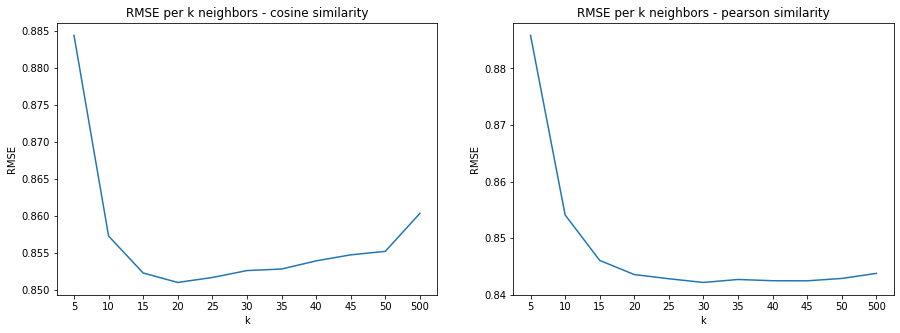

In [72]:
# Visualization of results
import matplotlib.pyplot as plt

k_options = np.concatenate((np.arange(5,55,5), [500]))
k_labels = [str(i) for i in k_options]

fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].plot(rmse_scores_cos)
ax[0].set_xticks(np.arange(0,11, 1))
ax[0].set_xticklabels(k_labels)
ax[0].set_xlabel('k')
ax[0].set_ylabel('RMSE')
ax[0].set_title('RMSE per k neighbors - cosine similarity')

ax[1].plot(rmse_scores_pear)
ax[1].set_xticks(np.arange(0,11, 1))
ax[1].set_xticklabels(k_labels)
ax[1].set_xlabel('k')
ax[1].set_ylabel('RMSE')
ax[1].set_title('RMSE per k neighbors - pearson similarity')

plt.show()

In [73]:
# Optimal parameters
if lowest_rmse_cos < lowest_rmse_pear:
    opt_sim = 'cosine'
    opt_k = optimal_k_cos
    print('the optimal similarity measure is cosine similarity with an optimal k of', opt_k)

else:
    opt_sim = 'pearson'
    opt_k = optimal_k_pear
    print('the optimal similarity measure is pearson similarity with an optimal k of', opt_k)


the optimal similarity measure is pearson similarity with an optimal k of 30


We can see that we obtain the best RMSE with pearson similarity measure and with a number of neighbors k = 30. We now fit our train set with these hyperparameters and predict the results on our test set, before computing the precision, recall, and novelty.

In [75]:
#Format change for trainset (necessary for surprise)
trainset = ratings.build_full_trainset()
testset = ratings_test.raw_ratings
testset = ratings.construct_testset(testset)

opt_model = KNNWithMeans(sim_options ={'name': 'pearson', 'user_based':False}, k = optimal_k_pear)

opt_model.fit(trainset)
results = opt_model.test(testset)

test_result = opt_model.test(testset)
test_rmse = accuracy.rmse(test_result)

# get dictionary and df to use for precision and recall
test_item = pd.DataFrame(test_result).sort_values(['uid','est'],ascending=False).groupby('uid').head(10)
test_item = test_item.rename(columns={"uid": "userId", "est": "rating", "iid": "movieId"})
test_item_temp = test_item.groupby(['userId'])['movieId'].agg(lambda x: list(x))
test_item_dict = {}
for user, watched_movies in zip(test_item_temp.index, test_item_temp):
    test_item_dict[user] = watched_movies

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8343


In [76]:
cf_precision = precision(test_item_dict, test_item)
cf_recall = recall(test_item_dict, test_item)
cf_novelty = novelty(test_item_dict)

In [77]:
print('The precision of our best Item-Based CF model is:', round(cf_precision,2))
print('The recall of our best Item-Based CF model is:', round(cf_recall,2))
print('The novelty of our best Item-Based CF model is:',  round(cf_novelty,2))

The precision of our best Item-Based CF model is: 0.72
The recall of our best Item-Based CF model is: 1.0
The novelty of our best Item-Based CF model is: 8.25


In [78]:
# save and output recommendations
user_recs = {}
for user in test_item['userId'].unique():
    user_item = test_item[test_item['userId'] == user]
    best_movies = list(user_item['movieId'].head(10))
    user_recs[user] = best_movies

In [79]:
# pickle model - need to get actual predictions
file_to_write = open("outputs/item_based.pickle", "wb")
pickle.dump(user_recs, file_to_write)

### 5. Hybrid Model

Below, we built our hybrid models by combining model recommendations from an Item-Based Collaborative Filtering model, an Autoencoder model, and a Content-Based model. For more information on how we built and evaluated the Autoencoder and Content-Based algorithms, please see the Deep_Learning_Model_Autoencoders and Content-based notebooks, respectively.

For all three of the hybrid models, we output up to 10 recommended movies per user in a dictionary format with key = userId and value = a list of recommended movies for that user. We then pickled all these dictionaries and stored them in the output/ folder to make the models' recommendations easy to retrieve and combine in the following hybrid models. 

First, we split the datasets into the quantile user groups as mentioned in our introductory section. We make different data splits for each of our three hybrid models according to their format.

#### 5.1 Splitting the datasets for routing into correct hybrid model

In [8]:
#splitting datasets based on quartile for number of movies watched
def user_split(data, split_at_quantile_lst):
    if len(split_at_quantile_lst) == 1:
        distribution = pd.DataFrame(data['userId'].value_counts().rename_axis('userId').reset_index(name = 'counts'))
        thresh = distribution.counts.quantile(split_at_quantile_lst[0])
        user_ids_below = distribution[distribution.counts <= thresh]
        user_ids_below = user_ids_below['userId'].to_list()
        user_ids_above = distribution[distribution.counts > thresh]
        user_ids_above = user_ids_above['userId'].to_list()
        data_below = data[data['userId'].isin(user_ids_below)]
        data_above = data[data['userId'].isin(user_ids_above)]
        return data_below, data_above
    elif len(split_at_quantile_lst) == 2:
        distribution = pd.DataFrame(data['userId'].value_counts().rename_axis('userId').reset_index(name = 'counts'))
        thresh = distribution.counts.quantile(split_at_quantile_lst[0])
        user_ids_low = distribution[distribution.counts <= thresh]
        user_ids_low = user_ids_low['userId'].to_list()
        thresh2 = distribution.counts.quantile(split_at_quantile_lst[1])
        user_ids_middle = distribution[(distribution.counts <= thresh2) & (distribution.counts > thresh)]
        user_ids_middle = user_ids_middle['userId'].to_list()
        user_ids_high = distribution[distribution.counts > thresh2]
        user_ids_high = user_ids_high['userId'].to_list()
        data_lowest = data[data['userId'].isin(user_ids_low)]
        data_middle = data[data['userId'].isin(user_ids_middle)]
        data_high = data[data['userId'].isin(user_ids_high)]
        return data_lowest, data_middle, data_high

Here are the various formats of the three hybrid models we try.

(1) Hybrid Model 1

> User group 1 (<25th percentile of movies watched)           ---->     Content-Based Model  <br>
> User group 2 (>25th, <75th percentile of movies watched)    ---->     Item-Based Collaborative Filtering <br>
> User group 3 (>75th percentile of movies watched)           ---->     Autoencoder   <br>

(2) Hybrid Model 2

> User group 1 and 2 (<75th percentile of movies watched)     ---->     Item-Based Collaborative Filtering <br>
> User group 3 (>75th percentile of movies watched)           ---->     Autoencoder   <br>

(3) Hybrid Model 3

> User group 1 (<25th percentile of movies watched)           ---->     Content-Based Model  <br>
> User group 2 and 3 (>25th percentile of movies watched)     ---->     Item-Based Collaborative Filtering <br>

In [12]:
#model 1 sets
content_train1, cf_train1, autoencoder_train1 = user_split(train_ratings, [0.25, 0.75])
content_val1, cf_val1, autoencoder_val1 = user_split(val_ratings, [0.25, 0.75])
content_test1, cf_test1, autoencoder_test1 = user_split(test_ratings, [0.25, 0.75])

#model 2 sets
cf_train2, autoencoder_train2 = user_split(train_ratings, [0.75])
cf_val2, autoencoder_val2 = user_split(val_ratings, [0.75])
cf_test2, autoencoder_test2 = user_split(test_ratings, [0.75])

#model 3 sets
content_train3, cf_train3 = user_split(train_ratings, [0.25])
content_val3, cf_val3 = user_split(val_ratings, [0.25])
content_test3, cf_test3 = user_split(test_ratings, [0.25])

Next, we read in the recommendations for each user in our test set. As mentioned above, we pickled the dictionaries with recommended outputs for each user for all trained models for easy access and use in the hybrid model. We get the relevant ratings for each user based on which user group they fall into (based on # movies rated) and essentially concatenate the dictionary recommendations so that we have one dictionary for each of our three hybrid systems.

In [13]:
cf_dict = pickle.load(open( "outputs/item_based.pickle", "rb"))
ae_dict = pickle.load(open("outputs/DL_recommendations.pickle", "rb"))
content_dict = pickle.load(open("outputs/all_content_recommendations.pickle", "rb"))

In [14]:
# create 3 dicts for item-based cf (one for each system)
cf_dict1 = {key: value for key, value in cf_dict.items() if key in cf_test1['userId'].unique()}
cf_dict2 = {key: value for key, value in cf_dict.items() if key in cf_test2['userId'].unique()}
cf_dict3 = {key: value for key, value in cf_dict.items() if key in cf_test3['userId'].unique()}

In [15]:
# create 2 dicts for content-based (one for system 1 and one for system 3)
content_dict1 = {key: value for key, value in content_dict.items() if key in content_test1['userId'].unique()}
content_dict3 = {key: value for key, value in content_dict.items() if key in content_test3['userId'].unique()}

In [16]:
# concatenate so we have one overall dictionary per system
hybrid1_recs = content_dict1.copy()
hybrid1_recs.update(cf_dict1)
hybrid1_recs.update(ae_dict)

hybrid2_recs = cf_dict2.copy()
hybrid2_recs.update(ae_dict)

hybrid3_recs = content_dict3.copy()
hybrid3_recs.update(cf_dict3)

#### 5.2 Model Evaluation
Here, we evaluate each of the three hybrid models to find the best one and use that in the following section as our ultimate recommender system.

In [86]:
# for each system, get precision, recall, and novelty
hybrid1_precision = precision(hybrid1_recs, test_ratings)
hybrid2_precision = precision(hybrid2_recs, test_ratings)
hybrid3_precision = precision(hybrid3_recs, test_ratings)

hybrid1_recall = recall(hybrid1_recs, test_ratings)
hybrid2_recall = recall(hybrid2_recs, test_ratings)
hybrid3_recall = recall(hybrid3_recs, test_ratings)

hybrid1_novelty = novelty(hybrid1_recs)
hybrid2_novelty = novelty(hybrid2_recs)
hybrid3_novelty = novelty(hybrid3_recs)

In [87]:
table = [["", "Precision", "Recall", "Novelty"],
         ["Baseline", round(baseline_precision, 2), round(baseline_recall, 2), round(baseline_novelty, 2)],
         ["Item-Based Collaborative Filtering", round(cf_precision, 2), round(cf_recall, 2), round(cf_novelty, 2)],
         ["Hybrid Model 1", round(hybrid1_precision, 2), round(hybrid1_recall, 2), round(hybrid1_novelty, 2)],
         ["Hybrid Model 2", round(hybrid2_precision, 2), round(hybrid2_recall, 2), round(hybrid2_novelty, 2)],
         ["Hybrid Model 3", round(hybrid3_precision, 2), round(hybrid3_recall, 2), round(hybrid3_novelty, 2)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

,Precision,Recall,Novelty
Baseline,0.71,0.81,8.23
Item-Based Collaborative Filtering,0.72,1.0,8.25
Hybrid Model 1,0.32,0.37,8.65
Hybrid Model 2,0.57,0.73,7.49
Hybrid Model 3,0.47,0.46,9.39


In [119]:
#pickle the best hybrid model - model 2
file_to_write = open("outputs/hybrid2_recs.pickle", "wb")
pickle.dump(hybrid2_recs, file_to_write)

### 6. Recommendations and Conclusion

Interestingly enough, our best hybrid model in terms of precision and recall is number 2, which uses Item-Based Collaborative Filtering for all users below the 75th percentile of number of movies watched and Autoencoders for users above the 75th percentile. This perhaps implies that the content-based model did not work particularly well and ultimately was unable to solve the cold start problem for CF. Thus, we proceed onwards with hybrid model 2 to make recommendations.

Below, we create a function that returns the names of the Top 10 recommended movies from our second hybrid system for any user of interest. Because we want this function to run completely end to end, we recreate our recommendation dictionary again inside.

In [122]:
def recommend_movies(user):
    # import movies so we can show titles
    movies = pd.read_csv("inputs/movies.csv")
    movies_dict = dict(zip(movies.movieId, movies.title))
    #load the recommendations
    hybrid2_recs = pickle.load(open("outputs/hybrid2_recs.pickle","rb"))
    #get movie ids
    movie_recs = hybrid2_recs[user]
    #look up movie titles and rank them
    movie_titles = []
    i = 1
    for movie in movie_recs:
        #clean title
        t = movies_dict[movie]
        t = str.strip(t)
        clean_title = t[:-7]
        if('The' in clean_title[-3:]):
            clean_title = 'The ' + clean_title[:-5]
        if('A' in clean_title[-1:]):
            clean_title = 'A ' + clean_title[:-3]
        movie_titles.append(str(i) + '. ' + str(clean_title))
        i += 1
    #output recs for user
    print("Based on your viewing history, we recommend the following movies for you to try next: \n \t" + '\n \t'.join([str(m) for m in movie_titles]))

We show recommendations for one user who was routed to the item-based algorithm and one user who was routed to the autoencoder algorithm by randomly selecting one user from each of the corresponding test sets. We take a qualitative look at these recommendations and also show them as a proof of concept.

In [24]:
#commented out in order to maintain the same users
#randomly select one user from item-based
#cf_test2 = cf_test2.reset_index()
#random1 = random.randint(0,len(cf_test2))
#user1 = cf_test2.loc[random1,'userId']
#randomly select one user from autoencoders
#autoencoder_test2 = autoencoder_test2.reset_index()
#random2 = random.randint(0,len(autoencoder_test2))
#user2 = autoencoder_test2.loc[random2,'userId']

In [118]:
#print("The user we selected from the item-based group is User " + str(user1) + "\n" +
#     "The user we selected from the autoencoder group is User " + str(user2))

The user we selected from the item-based group is User 26764
The user we selected from the autoencoder group is User 113660


First, we look at User 26764, who has rated 14 movies, placing him in the first quartile and routing him to the item-based algorithm. Our recommendations below are quite cohesive - we can deduce that this user is probably interested in action movies - yet the recommendations still offer a wide range of movies that fit into this genre (i.e. movies from wartime, like Courage Under Fire and The English Patient, are recommended, but so are fantasy movies, like Highlander and Star Wars).

In [123]:
recommend_movies(26764)

Based on your viewing history, we recommend the following movies for you to try next: 
 	1. Wallace & Gromit: The Best of Aardman Animation
 	2. Indiana Jones and the Last Crusade
 	3. Star Wars: Episode VI - Return of the Jedi
 	4. Before Sunrise
 	5. The Last of the Mohicans
 	6. Highlander
 	7. A Time to Kill
 	8. Courage Under Fire
 	9. The English Patient
 	10. Twister


Next, we look at User 113660, a frequent movie watcher (has rated 38 movies total) who we used the autoencoders to recommend movies to. This user also appears to enjoy action movies, and is even recommended 2 of the same movies as is our previous user (Star Wars and Indiana Jones; it is also likely that these two movies were quite popular). However, we can see that the types of action movies are quite different from our previous user and that this user's taste also appears to be more varied (recommendations include Being John Malkovich, a comedy, and two thrillers: Silence of the Lambs and Memento).

In [124]:
recommend_movies(113660)

Based on your viewing history, we recommend the following movies for you to try next: 
 	1. The Silence of the Lambs
 	2. The Lord of the Rings: The Fellowship of the Ring
 	3. Memento
 	4. The Princess Bride
 	5. Star Wars: Episode VI - Return of the Jedi
 	6. Taxi Driver
 	7. Indiana Jones and the Last Crusade
 	8. Terminator 2: Judgment Day
 	9. Being John Malkovich
 	10. Die Hard


Overall, we see some interesting results from our hybrid model. Two of our hybrid models are able to achieve higher novelty which indicates that perhaps these systems are able to provide more individualized recommendations to the users, even if they are not necessarily movies that the user will like more. However, all of the hybrid models performed worse than both the baseline and the item-based collaborative filtering model in terms of precision and recall. These results are relatively surprising because we had hoped the content-based model could help with collaborative filtering's cold start problem. By incorporating in various sources like MovieLens tag data as well as the abundant Wikipedia data we scraped, we had hoped to create great movie representations. Perhaps, however, the very high number of tags and Wiki terms actually created overly high dimensional movie vectors that could not generalize well. We also thought Autoencoders could be an exciting technique for the most frequent movie watcher group, but these results actually show that sometimes the simplest models are truly good enough (if not the best).

We specifically focused on creating hybrid models that addressed user groups differently based on their rating frequency, but it seems that baseline and collaborative filtering handle these user groups better than content-based and deep learning. Future work could involve more intentional user segmentation by examining the CF cold start problem more closely.

Another limitation of our model's output is that not all users are actually given 10 recommendations, which would not be very useful for an actual company's solution. This is a potential watchout, but in the future, we could try combining various models' outputs in order to guarantee 10 recommendations per user.

Our final recommendation to the manager would simply be to use the item-based recommender system over the hybrid system. While novelty is a nice feature to have, ultimately we believe that the priority for the hiring manager should be to show the user movies that he will watch and enjoy. Therefore, when comparing hybrids on their own, we would recommend hybrid model 2 to the hiring manager, even though it has the lowest novelty of all of our models. However, across all models, our ultimate recommendation is to use the Item-Based Collaborative Filtering system due to its superior performance across all three metrics we measure. 

Finally, we would encourage the manager to try to experiment with other ensemble techniques. For example, instead of segregating users into groups based on certain criteria, we could instead try aggregating different models' predictions on all users. Additionally, we would recommend that the manager try utilizing user data, such as any demographic data the user provides when signing up to use the service or any other available information, such as search and click history, to try and improve recommendations, specifically for the cold start problem when little to no ratings are available.